© 2018 Suzy Beeler and Vahe Galstyan. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

This exercise was generated from a Jupyter notebook. You can download the notebook [here](diffusion_master_equation.ipynb).
___

# Objective 

[Previously](diffusion_via_coin_flips.html) we used a random number generator to obtain stochastic trajectories of diffusive particles. By overlaying lots of such trajectories, we got intuition about the evolution of the probability distribution of walker's position over time. In this tutorial, we will get at this probability distribution more directly by using numerical integration of a master equation for diffusion. 

# Master equation for diffusion 

As covered in lecture, we can write down the following "master equation" to describe diffusion: 

\begin{align}
\overbrace{p(n,t + \Delta t)}^{\text{new probability}} = 
\underbrace{p(n, t)}_{\text{old probability}} + 
\overbrace{k \Delta t p(n-1, t)}^{\text{jumping from the left}} + 
\underbrace{k \Delta t p(n+1, t)}_{\text{jumping from the right}} - 
\overbrace{k \Delta t p(n,t)}^{\text{jumping to the left}} -
\underbrace{k \Delta t p(n,t)}^{\text{jumping to the right}}
. \tag{1}
\end{align}

This master equation allows us to calculate the probability of the walker being at position $n$ at the next time step $t + \Delta t$, given the probabilities at the current time step $t$. $k$ is the hopping rate between neighboring positions, and $\Delta t$ is the time step used in the numerical calculation.

The master equation at the boundaries is slightly modified and is given by

\begin{align}
\overbrace{p(0,t + \Delta t)}^{\text{new probability}} = 
\underbrace{p(0, t)}_{\text{old probability}} + 
\overbrace{k \Delta t p(1, t)}^{\text{jumping from the right}} - 
\underbrace{k \Delta t p(0,t)}^{\text{jumping to the right}}. \tag{2}
\end{align}

for the left edge, and

\begin{align}
\overbrace{p(N,t + \Delta t)}^{\text{new probability}} = 
\underbrace{p(N, t) }_{\text{old probability}} + 
\overbrace{k \Delta t p(N-1, t)}^{\text{jumping from the right}} - 
\underbrace{k \Delta t p(N,t)}^{\text{jumping to the left}}. \tag{3}
\end{align}

for the right edge, where $N$ is the index of the right-most position. These boundary conditions are specified so that particles at the left-most edge can only move to the right and particles at the right-most edge can only move to the left. 

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for nice plots
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
    'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
sns.set(rc=rc)

# Import the utilities file
import pboc_utils as pboc

# Diffusion of a point source

For our first numerical integration, let's see how an initial point source of particles diffuse over time. To do this, we will set up an array of boxes through which our particles will diffuse, and we will specify the box in the center to initially have probability $1$ (i.e. *all* the particles are found here) and all other boxes will have probability $0$. To do that, we specify the number of boxes, the time increment, the number of time steps and the hopping rate. In general, the time increment needs to be smaller than the hopping timescale to ensure accurate estimation, as we discussed in the [forward euler](forward_euler.ipynb) exercise.

In [2]:
# number of boxes
n_boxes = 40

# time increment (Delta t) in seconds
dt = 0.1

# number of steps
n_steps = 100

# hopping rate constant (k) in sec^-1
k = 1

# initialize the probability distribution
p = np.zeros([n_boxes, n_steps])

# find the middle box
n_center = int(n_boxes / 2)

# set the middle box to have probability 1 at the initial time step 
p[n_center, 0] = 1

Now we can solve the master equation iteratively, by using the probabilities at the previous time step $t-1$ to evaluate those at the current time step $t$.

In [3]:
# loop through the number of steps
for t in range(1, n_steps):
    
    # update probability array in the interior region
    for b in range(1,n_boxes-1):
        p[b,t] = p[b,t-1] + k*dt*p[b-1,t-1] + k*dt*p[b+1,t-1] - 2*k*dt*p[b,t-1]

    # update probability array for the left-most box
    p[0,t] = p[0,t-1] + k*dt*p[1,t-1] - k*dt*p[0,t-1]
    
    # update probability array for the right-most box
    # note that -1 corresponds to the last item
    p[-1, t] = p[-1, t-1] + k*dt*p[-2,t-1] - k*dt*p[-1, t-1]

To display the probabilities at different points in time, we will use the custom-written `bar_plot` function in the [`pboc_utilities.py`](pboc_utilities.py) utilities file. As inputs, it takes the 2-dimensional probability array `p`, the number of time slices `n_slices`, the time increment `dy` and the axis labels `x_label` and `y_label`.

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x1a1fce8898>)

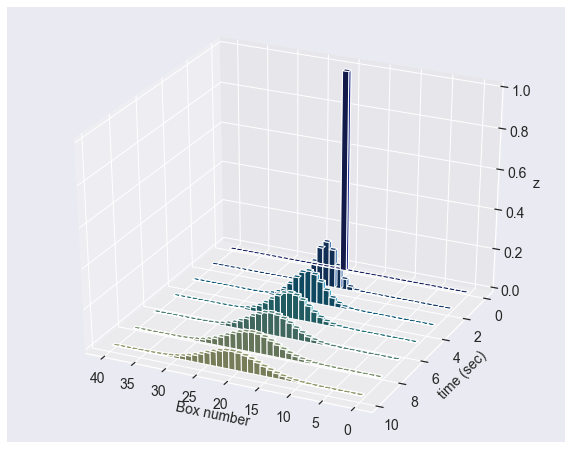

In [4]:
pboc.bar_plot(p, n_slices = 6, dy = dt, x_label='Box number', y_label='time (sec)')

As we can see, as time progresses, the probability distribution becomes wider and remains centered around the original position of the walker. This result is similar to what we found [previously](diffusion_via_coin_flips.html), but here we've gotten the solution explicitly rather than stochastically. That is, at every time point instead of relying on coin flips, we explicitly calculated how much of the probability should be moving to the left and to right. 

# FRAP

Having developed the numerical method of integrating the master equation, let's consider its application to the problem of fluorescence recovery after photobleaching (FRAP). In FRAP experiments, the fluorescently labeled molecules initially have a uniform distribution. Applying high intensity light, the fluorescent molecules in the desired region get photobleached, meaning that they no longer fluoresce. Over time, the fluorescent molecules that were outside the photobleached region will diffuse into it, recovering the uniform fluorescence distribution. By estimating the timescale of fluorescence recovery, experimentalists can determine the diffusion constant of fluorescently labeled molecules.

In this part of the tutorial we will implement the 1-dimensional version of the FRAP experiment. We will initialize the probability distribution as zero in the middle region and uniform outside it. We will when observe the process of recovery as the gap gets "filled" with probability from the two flanking regions.

In [5]:
# need more time steps this time
n_steps = 1000

# initialize the probability distribution
p = np.zeros([n_boxes, n_steps])

# assign non-zero values to the first time step
p[:,0] = 1

# number boxes to photobleach
n_bleach = 10 

# find start and end positions for the photobleached region
start = n_center - int(n_bleach/2)
end = n_center + int(n_bleach/2)

# do the "photobleach" by setting the probabilty to 0 
p[start:end,0] = 0

# re-normalization so probability sums to 1
p[:,0] = p[:,0] / np.sum(p[:,0])

Now we can run the same code from before, just with this new initial condition specified in the probability array. 

In [6]:
# loop through the number of steps
for t in range(1, n_steps):
    
    # update probability array in the interior region
    for b in range(1,n_boxes-1):
        p[b,t] = p[b,t-1] + k*dt*p[b-1,t-1] + k*dt*p[b+1,t-1] - 2*k*dt*p[b,t-1]

    # update probability array for the left-most box
    p[0,t] = p[0,t-1] + k*dt*p[1,t-1] - k*dt*p[0,t-1]
    
    # update probability array for the right-most box
    # noteL p[-1,t] chooses the last row and the t-th column
    p[-1, t] = p[-1, t-1] + k*dt*p[-2,t-1] - k*dt*p[-1, t-1]

Now let's use the utility function `bar_plot` to show the process of recovery.

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x1c21afd160>)

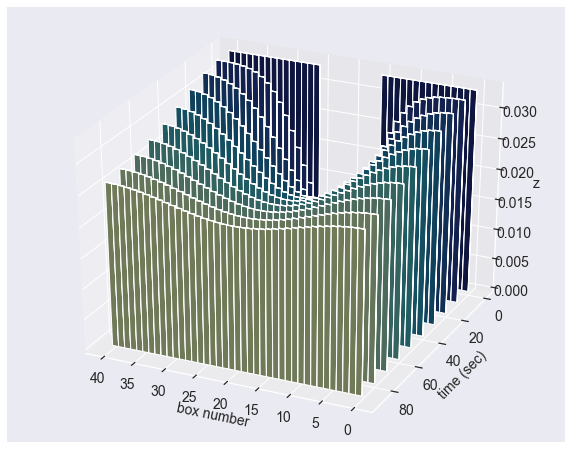

In [7]:
pboc.bar_plot(p, n_slices = 10, dy = dt, x_label='box number', y_label='time (sec)')